In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import torch
import rosenbrock as R
import booth as B
from plot_trajectory import plot_trajectory
import matplotlib.pyplot as plt

torch.manual_seed(102)
plt.rcParams.update({'font.size': 22, 'font.family': 'serif'})

In [8]:
from tqdm.auto import tqdm
from torch.autograd import grad

def symmetry_teleportation(x, func, teleport_func, teleport_lr, inner_iters):
    theta = torch.tensor([2 * torch.pi * torch.rand(1)], requires_grad=True)
    opt = torch.optim.SGD([theta], lr=teleport_lr, maximize=True)
    for i in range(inner_iters):
        x_theta = teleport_func(x, theta)
        loss = func(x_theta)
        grads = grad(loss, x_theta, create_graph=True)[0]

        opt.zero_grad()
        grad_norm_sq = grads.square().sum()
        theta.grad = grad(grad_norm_sq, theta)[0]
        opt.step()

    return teleport_func(x, theta)

def grad_descent(func, lr, iters, init, teleport_iters, teleport_func, teleport_lr, inner_iters):
    loss_history, grad_norm_history, x_history = [], [], []

    x = torch.tensor(init, requires_grad=True)
    opt = torch.optim.SGD([x], lr=lr)
    x_history += [x.detach().clone()]

    for i in tqdm(range(1, iters + 1)):
        if i in teleport_iters:
            x = symmetry_teleportation(x, func, teleport_func, teleport_lr, inner_iters).detach()
            x = x.clone().detach().requires_grad_(True)
            opt = torch.optim.SGD([x], lr=lr)

            opt.zero_grad()
            loss = func(x)
            loss.backward()
            loss_history += [loss.item()]
            grad_norm_history += [torch.norm(x.grad).item()]
            x_history += [x.detach().clone()]
        else:
            opt.zero_grad()
            loss = func(x)
            loss.backward()
            loss_history += [loss.item()]
            grad_norm_history += [torch.norm(x.grad).item()]
            opt.step()
            x_history += [x.detach().clone()]

    x_history = torch.stack(x_history, dim=0)
    return loss_history, grad_norm_history, x_history

In [9]:
loss_gd, grad_norm_gd, x_gd = grad_descent(
    func=R.rosenbrock, lr=1e-3, iters=1000, init=[-1., -1.],
    teleport_iters=[], teleport_func=R.teleport_rosenbrock,
    teleport_lr=0.1, inner_iters=10
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
loss_tp, grad_norm_tp, x_tp = grad_descent(
    func=R.rosenbrock, lr=1e-3, iters=1000, init=[-1., -1.],
    teleport_iters=list(range(100, 1000, 100)), teleport_func=R.teleport_rosenbrock,
    teleport_lr=0.1, inner_iters=10
)

  0%|          | 0/1000 [00:00<?, ?it/s]

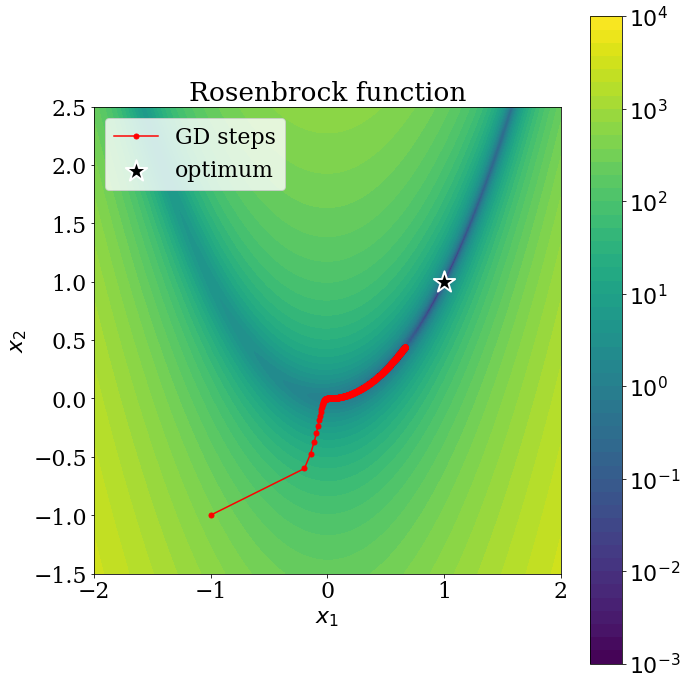

In [11]:
x_true = torch.ones(2)
plot_trajectory(
    x_gd, x_true, save_path='images/rosenbrock-gd-trajectory.png',
    func=R.rosenbrock, name='Rosenbrock function', xlim=(-2, 2), ylim=(-1.5, 2.5),
    teleports=[], label='GD steps'
)

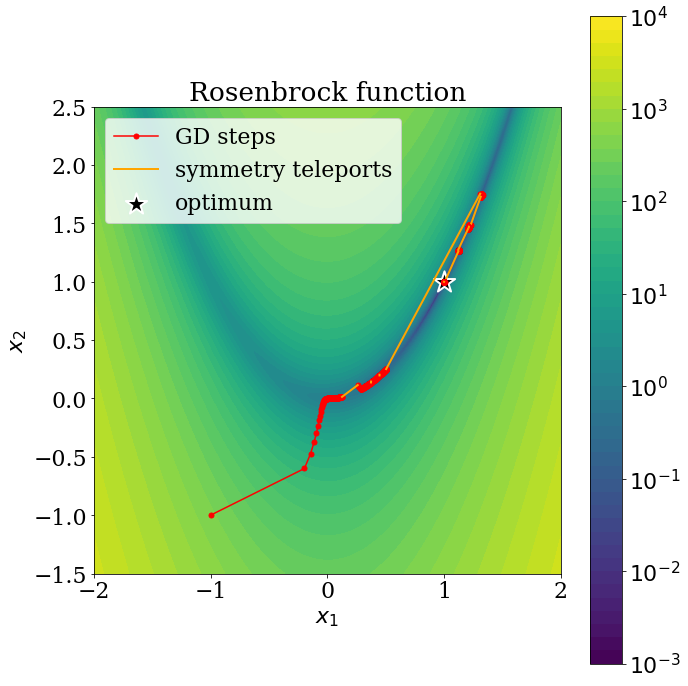

In [12]:
x_true = torch.ones(2)
plot_trajectory(
    x_tp, x_true, save_path='images/rosenbrock-tp-trajectory.png',
    func=R.rosenbrock, name='Rosenbrock function', xlim=(-2, 2), ylim=(-1.5, 2.5),
    teleports=list(range(100, 1000, 100)), label='GD steps'
)

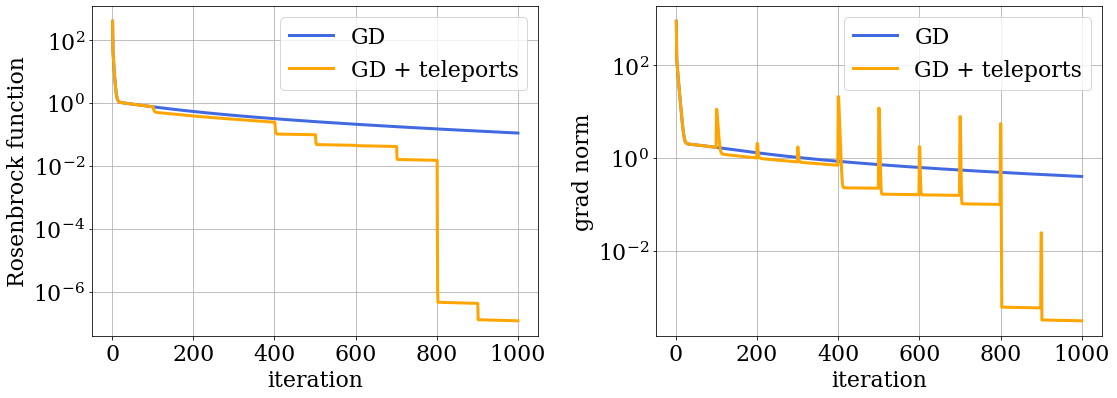

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].plot(range(1, 1001), loss_gd, label='GD', color='royalblue', linewidth=3)
axs[0].plot(range(1, 1001), loss_tp, label='GD + teleports', color='orange', linewidth=3)
axs[1].plot(range(1, 1001), grad_norm_gd, label='GD', color='royalblue', linewidth=3)
axs[1].plot(range(1, 1001), grad_norm_tp, label='GD + teleports', color='orange', linewidth=3)

axs[0].set_ylabel('Rosenbrock function')
axs[1].set_ylabel('grad norm')

for ax in axs:
    ax.set_yscale('log')
    ax.set_xlabel('iteration')
    ax.grid()
    ax.legend()

plt.tight_layout()
plt.savefig('images/rosenbrock-training.png')
plt.show()

In [14]:
torch.manual_seed(103)
loss_gd, grad_norm_gd, x_gd = grad_descent(
    func=B.booth, lr=0.08, iters=10, init=[5., -5.],
    teleport_iters=[], teleport_func=B.teleport_booth,
    teleport_lr=0.001, inner_iters=10
)

  0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
loss_tp, grad_norm_tp, x_tp = grad_descent(
    func=B.booth, lr=0.08, iters=10, init=[5., -5.],
    teleport_iters=[5], teleport_func=B.teleport_booth,
    teleport_lr=0.1, inner_iters=10
)

  0%|          | 0/10 [00:00<?, ?it/s]

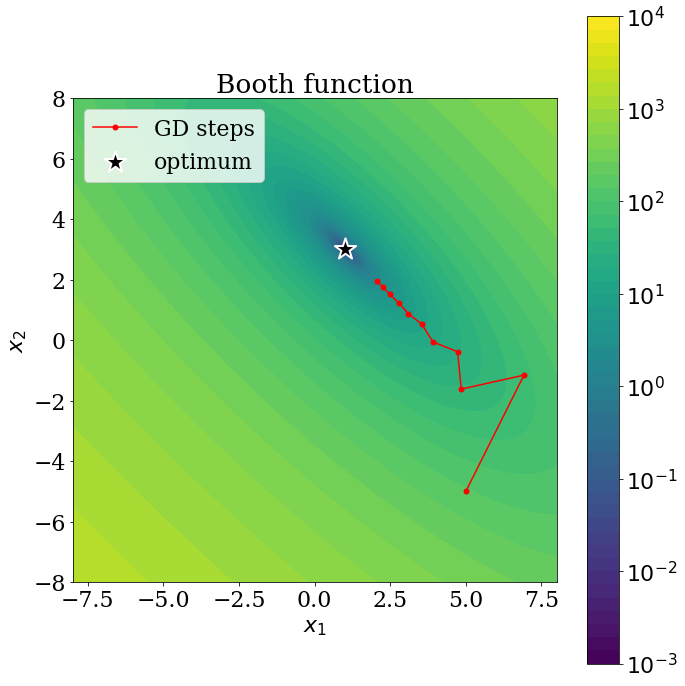

In [16]:
x_true = torch.tensor([1., 3.])
plot_trajectory(
    x_gd, x_true, save_path='images/booth-gd-trajectory.png',
    func=B.booth, name='Booth function', xlim=(-8, 8), ylim=(-8, 8),
    teleports=[], label='GD steps'
)

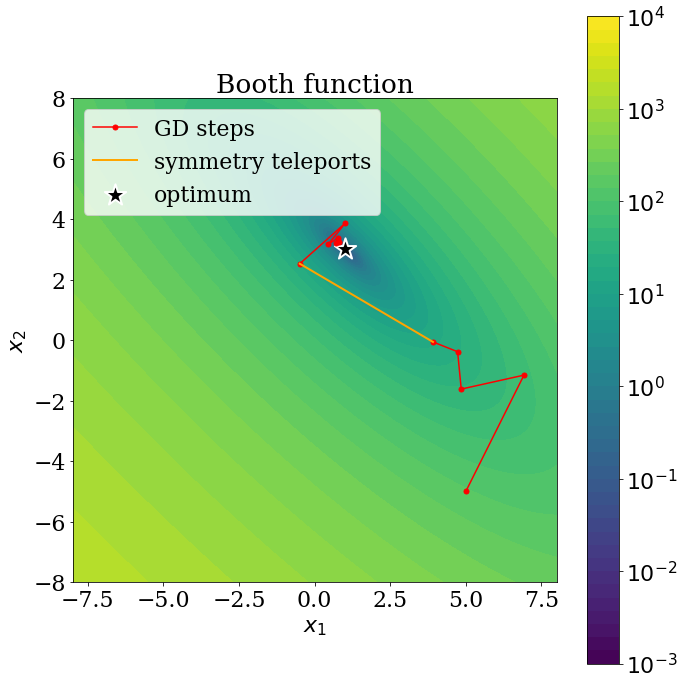

In [17]:
x_true = torch.tensor([1., 3.])
plot_trajectory(
    x_tp, x_true, save_path='images/booth-tp-trajectory.png',
    func=B.booth, name='Booth function', xlim=(-8, 8), ylim=(-8, 8),
    teleports=[5], label='GD steps'
)

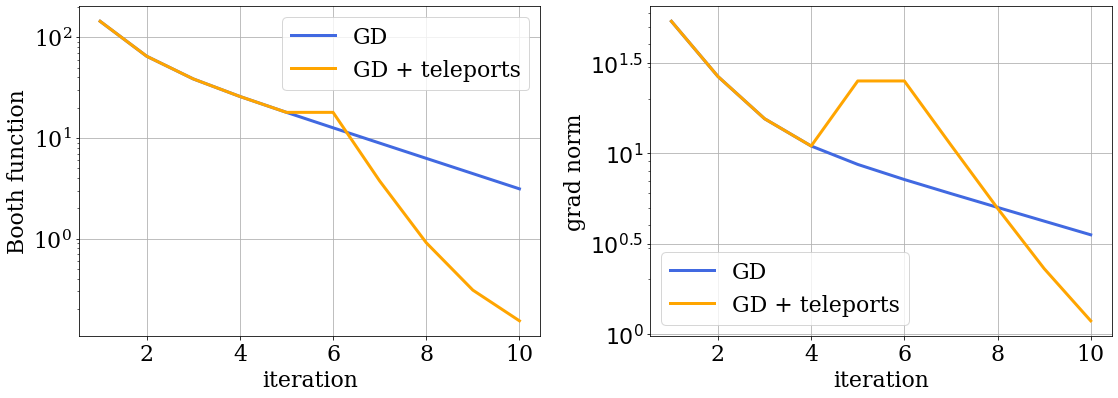

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].plot(range(1, 11), loss_gd, label='GD', color='royalblue', linewidth=3)
axs[0].plot(range(1, 11), loss_tp, label='GD + teleports', color='orange', linewidth=3)
axs[1].plot(range(1, 11), grad_norm_gd, label='GD', color='royalblue', linewidth=3)
axs[1].plot(range(1, 11), grad_norm_tp, label='GD + teleports', color='orange', linewidth=3)

axs[0].set_ylabel('Booth function')
axs[1].set_ylabel('grad norm')

for ax in axs:
    ax.set_yscale('log')
    ax.set_xlabel('iteration')
    ax.grid()
    ax.legend()

axs[1].set_yticks(
    ticks=[1, 10 ** 0.5, 10, 10 ** 1.5],
    labels=['$10^0$', '$10^{0.5}$', '$10^{1}$', '$10^{1.5}$']
)
plt.tight_layout()
plt.savefig('images/booth-training.png')
plt.show()